In [94]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string
import nltk
from nltk.corpus import stopwords
import re
from collections import Counter
import stanza
from spellchecker import SpellChecker
from nltk.corpus import words
import zemberek
from zemberek.morphology import TurkishMorphology
from zemberek.tokenization import TurkishTokenizer
from zemberek.normalization import TurkishSpellChecker
from zemberek.normalization import  TurkishSentenceNormalizer
import jpype
import jpype.imports
from jpype.types import JString

# READ DATA

In [95]:
df = pd.read_csv('tweets.csv')
df.head()

,timestamp,username,handle,tweet_date,content
0,2024-11-03 19:38:25,Orhan Şevik,orhan_sevik,"Feb 8, 2023",@haluklevent\n @OguzhanUgur\n hepinizden Alla...
1,2024-11-03 19:38:25,nursena,nurssxx_,"Feb 8, 2023",Allahım nolur sen onlara dayanma gücü ver #deprem
2,2024-11-03 19:38:25,Elif ŞEKER,55ellllllif,"Feb 8, 2023",Replying to \n@haluklevent\n @danlabilic\n and...
3,2024-11-03 19:38:25,Yusuf,yusufaltuns,"Feb 8, 2023",Tuğba södekoğlu kovulsun \n@showtv\n #deprem
4,2024-11-03 19:38:25,𝐎̈𝐳𝐠𝐮̈𝐫 𝐑𝐚𝐧,dryghtn2,"Feb 8, 2023",ARKADAŞIMIZA ULAŞAMIYORUZ\nKahramanmaraş Elbis...


# CHECK DATA

In [96]:
def checkData(data):
    print("****************SHAPE****************")
    print(data.shape)
    print("****************COLUMNS****************")
    print(data.columns)
    print("****************DTYPES****************")
    print(data.dtypes)    
    print("****************HEAD****************")
    print(data.head())
    print("****************Tail****************")
    print(data.tail())
    print("****************NA****************")
    print(data.isnull().sum())
    print("****************INFO****************")
    print(data.info())

checkData(df)

****************SHAPE****************
(2676, 5)
****************COLUMNS****************
Index(['timestamp', 'username', 'handle', 'tweet_date', 'content'], dtype='object')
****************DTYPES****************
timestamp     object
username      object
handle        object
tweet_date    object
content       object
dtype: object
****************HEAD****************
             timestamp     username       handle   tweet_date  \
0  2024-11-03 19:38:25  Orhan Şevik  orhan_sevik  Feb 8, 2023   
1  2024-11-03 19:38:25      nursena     nurssxx_  Feb 8, 2023   
2  2024-11-03 19:38:25   Elif ŞEKER  55ellllllif  Feb 8, 2023   
3  2024-11-03 19:38:25        Yusuf  yusufaltuns  Feb 8, 2023   
4  2024-11-03 19:38:25  𝐎̈𝐳𝐠𝐮̈𝐫 𝐑𝐚𝐧     dryghtn2  Feb 8, 2023   

                                             content  
0  @haluklevent\n @OguzhanUgur\n  hepinizden Alla...  
1  Allahım nolur sen onlara dayanma gücü ver #deprem  
2  Replying to \n@haluklevent\n @danlabilic\n and...  
3       Tuğba södekoğl

# Drop Duplicate & Nan

In [97]:
df = df.drop_duplicates(subset=["content"], keep="first").reset_index(drop=True)
df = df.dropna(subset=["content"]).reset_index(drop=True)
checkData(df)

****************SHAPE****************
(2437, 5)
****************COLUMNS****************
Index(['timestamp', 'username', 'handle', 'tweet_date', 'content'], dtype='object')
****************DTYPES****************
timestamp     object
username      object
handle        object
tweet_date    object
content       object
dtype: object
****************HEAD****************
             timestamp     username       handle   tweet_date  \
0  2024-11-03 19:38:25  Orhan Şevik  orhan_sevik  Feb 8, 2023   
1  2024-11-03 19:38:25      nursena     nurssxx_  Feb 8, 2023   
2  2024-11-03 19:38:25   Elif ŞEKER  55ellllllif  Feb 8, 2023   
3  2024-11-03 19:38:25        Yusuf  yusufaltuns  Feb 8, 2023   
4  2024-11-03 19:38:25  𝐎̈𝐳𝐠𝐮̈𝐫 𝐑𝐚𝐧     dryghtn2  Feb 8, 2023   

                                             content  
0  @haluklevent\n @OguzhanUgur\n  hepinizden Alla...  
1  Allahım nolur sen onlara dayanma gücü ver #deprem  
2  Replying to \n@haluklevent\n @danlabilic\n and...  
3       Tuğba södekoğl

In [98]:
df.to_csv('test.csv', index=False)

# Tweets Lower And Conver Str

In [99]:
df['content'] = df['content'].astype(str)
df['content'] = df['content'].str.lower()

# Count By Tweet Date

In [100]:
tweet_counts = df.groupby('tweet_date')['content'].count().sort_values(ascending=False)
print("=== Tweet Counts by Date ===")
print(tweet_counts)

=== Tweet Counts by Date ===
tweet_date
Feb 10, 2023    1030
Feb 7, 2023      559
Feb 9, 2023      440
Feb 8, 2023      359
Feb 6, 2023       49
Name: content, dtype: int64


# Hastags

In [101]:
hashtag_counts = df['content'].str.findall(r'#\w+').explode().value_counts()
print("=== Hashtag Counts ===")
print(hashtag_counts)

=== Hashtag Counts ===
content
#deprem                 2442
#hatay                   364
#depremsondakika         185
#hatayyardimbekliyor     180
#afad                    136
                        ... 
#afetbölgesi               1
#enkazdan                  1
#çağlayancerit             1
#depremani                 1
#coğrafyadersi             1
Name: count, Length: 767, dtype: int64


# Word Cloud

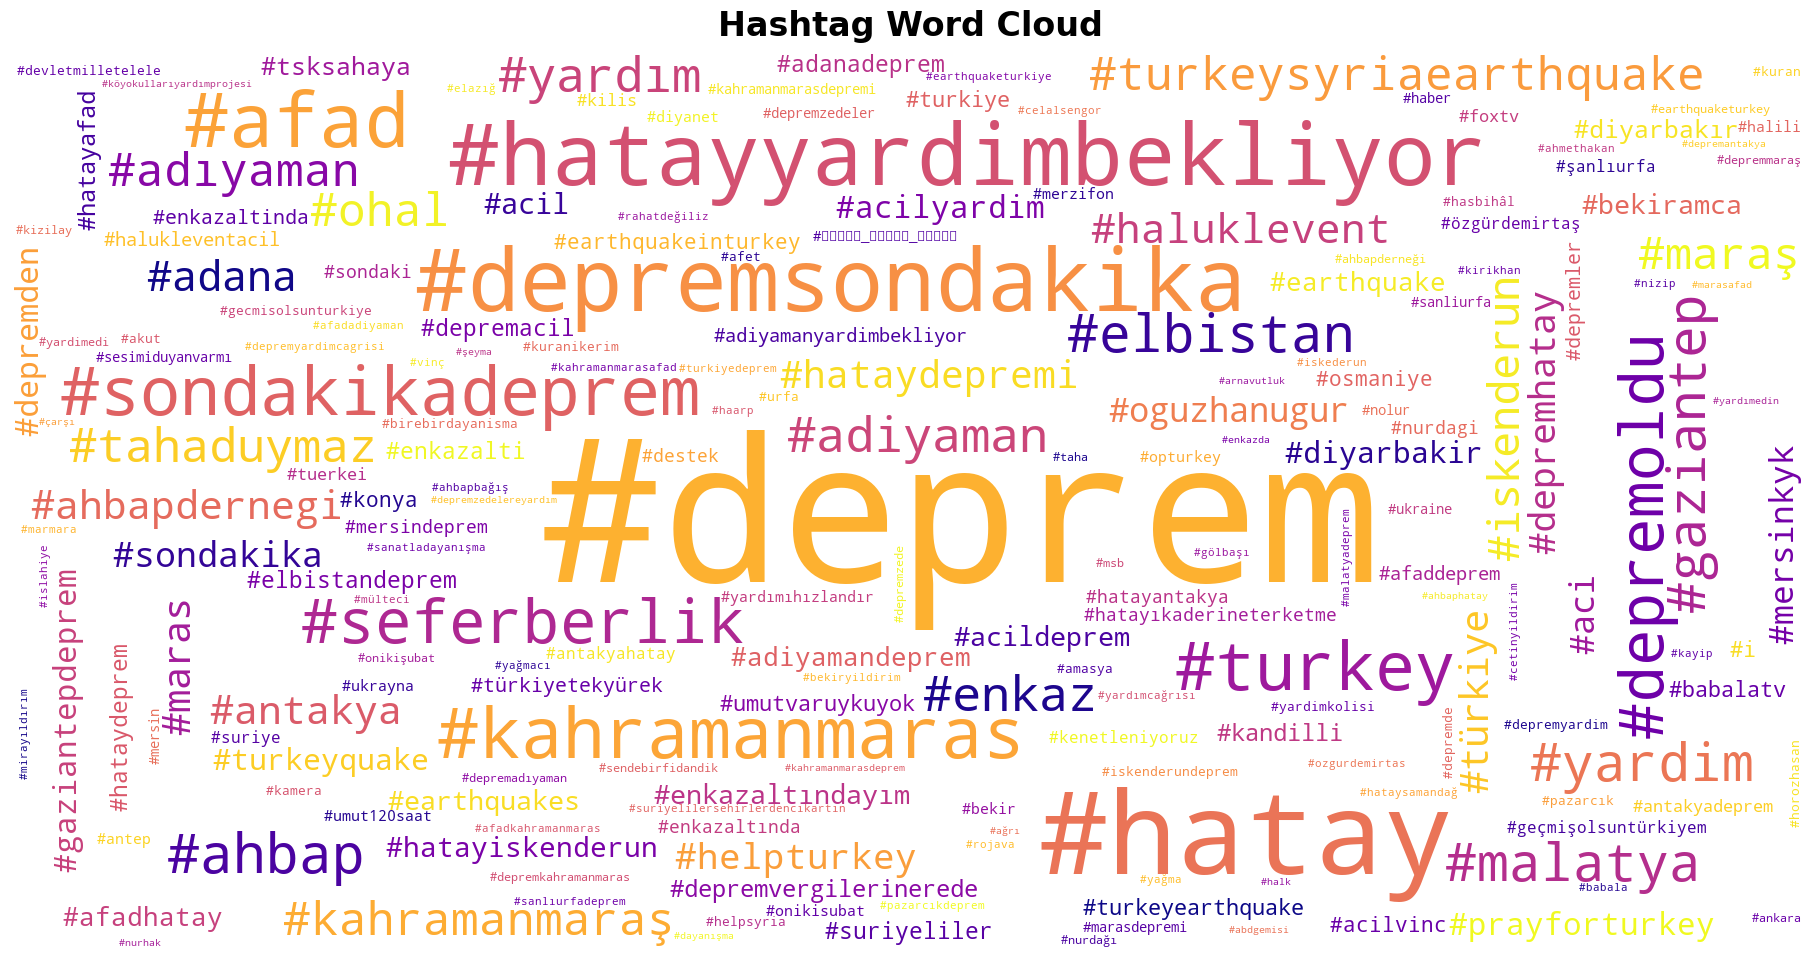

In [102]:
hashtag_dict = hashtag_counts.to_dict()
wordcloud = WordCloud(
    width=1800,
    height=900,
    background_color='white',       
    min_font_size=10,
    max_font_size=200,
    colormap='plasma',              
    contour_color='steelblue',       
    contour_width=1.5               
).generate_from_frequencies(hashtag_dict)
plt.figure(figsize=(18, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Hashtag Word Cloud', fontsize=24, fontweight='bold', pad=10)
plt.tight_layout(pad=0)
plt.show()

# Remove @ mentions and hyperlinks

In [103]:
def remove_mentions(text):
    return re.sub(r'@[A-Za-z0-9]+', '', text)

def remove_urls(text):
    text = re.sub(r'http\S+', '', text)  
    text = re.sub(r'www\S+', '', text)   
    return text

df['content_ment_link'] = df['content'].apply(lambda x: remove_mentions(x))
df['content_ment_link'] = df['content_ment_link'].apply(lambda x: remove_urls(x))
df.head()

,timestamp,username,handle,tweet_date,content,content_ment_link
0,2024-11-03 19:38:25,Orhan Şevik,orhan_sevik,"Feb 8, 2023",@haluklevent\n @oguzhanugur\n hepinizden alla...,\n \n hepinizden allah razı olsun iyiki varsı...
1,2024-11-03 19:38:25,nursena,nurssxx_,"Feb 8, 2023",allahım nolur sen onlara dayanma gücü ver #deprem,allahım nolur sen onlara dayanma gücü ver #deprem
2,2024-11-03 19:38:25,Elif ŞEKER,55ellllllif,"Feb 8, 2023",replying to \n@haluklevent\n @danlabilic\n and...,replying to \n\n \n and \n_harun\nadıyamanda a...
3,2024-11-03 19:38:25,Yusuf,yusufaltuns,"Feb 8, 2023",tuğba södekoğlu kovulsun \n@showtv\n #deprem,tuğba södekoğlu kovulsun \n\n #deprem
4,2024-11-03 19:38:25,𝐎̈𝐳𝐠𝐮̈𝐫 𝐑𝐚𝐧,dryghtn2,"Feb 8, 2023",arkadaşimiza ulaşamiyoruz\nkahramanmaraş elbis...,arkadaşimiza ulaşamiyoruz\nkahramanmaraş elbis...


## Removal of Punctuations

In [104]:
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df['content_wo_punct'] = df['content_ment_link'].apply(lambda x: remove_punctuation(x))
df['content_wo_punct'] = df['content_wo_punct'].str.replace('\n', ' ', regex=False)
df.head()

,timestamp,username,handle,tweet_date,content,content_ment_link,content_wo_punct
0,2024-11-03 19:38:25,Orhan Şevik,orhan_sevik,"Feb 8, 2023",@haluklevent\n @oguzhanugur\n hepinizden alla...,\n \n hepinizden allah razı olsun iyiki varsı...,hepinizden allah razı olsun iyiki varsını...
1,2024-11-03 19:38:25,nursena,nurssxx_,"Feb 8, 2023",allahım nolur sen onlara dayanma gücü ver #deprem,allahım nolur sen onlara dayanma gücü ver #deprem,allahım nolur sen onlara dayanma gücü ver deprem
2,2024-11-03 19:38:25,Elif ŞEKER,55ellllllif,"Feb 8, 2023",replying to \n@haluklevent\n @danlabilic\n and...,replying to \n\n \n and \n_harun\nadıyamanda a...,replying to and harun adıyamanda ali taş...
3,2024-11-03 19:38:25,Yusuf,yusufaltuns,"Feb 8, 2023",tuğba södekoğlu kovulsun \n@showtv\n #deprem,tuğba södekoğlu kovulsun \n\n #deprem,tuğba södekoğlu kovulsun deprem
4,2024-11-03 19:38:25,𝐎̈𝐳𝐠𝐮̈𝐫 𝐑𝐚𝐧,dryghtn2,"Feb 8, 2023",arkadaşimiza ulaşamiyoruz\nkahramanmaraş elbis...,arkadaşimiza ulaşamiyoruz\nkahramanmaraş elbis...,arkadaşimiza ulaşamiyoruz kahramanmaraş elbist...


## Remove Emojies & Numbers

In [105]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)
remove_emoji("game is on 🔥🔥")

'game is on '

In [106]:
def remove_numbers(text):
    return re.sub(r'[0-9]+', '', text)

df['content_wo_punct'] = df['content_wo_punct'].apply(lambda x: remove_emoji(x))
df['content_wo_punct'] = df['content_wo_punct'].apply(lambda x: remove_numbers(x))
df.head()

,timestamp,username,handle,tweet_date,content,content_ment_link,content_wo_punct
0,2024-11-03 19:38:25,Orhan Şevik,orhan_sevik,"Feb 8, 2023",@haluklevent\n @oguzhanugur\n hepinizden alla...,\n \n hepinizden allah razı olsun iyiki varsı...,hepinizden allah razı olsun iyiki varsını...
1,2024-11-03 19:38:25,nursena,nurssxx_,"Feb 8, 2023",allahım nolur sen onlara dayanma gücü ver #deprem,allahım nolur sen onlara dayanma gücü ver #deprem,allahım nolur sen onlara dayanma gücü ver deprem
2,2024-11-03 19:38:25,Elif ŞEKER,55ellllllif,"Feb 8, 2023",replying to \n@haluklevent\n @danlabilic\n and...,replying to \n\n \n and \n_harun\nadıyamanda a...,replying to and harun adıyamanda ali taş...
3,2024-11-03 19:38:25,Yusuf,yusufaltuns,"Feb 8, 2023",tuğba södekoğlu kovulsun \n@showtv\n #deprem,tuğba södekoğlu kovulsun \n\n #deprem,tuğba södekoğlu kovulsun deprem
4,2024-11-03 19:38:25,𝐎̈𝐳𝐠𝐮̈𝐫 𝐑𝐚𝐧,dryghtn2,"Feb 8, 2023",arkadaşimiza ulaşamiyoruz\nkahramanmaraş elbis...,arkadaşimiza ulaşamiyoruz\nkahramanmaraş elbis...,arkadaşimiza ulaşamiyoruz kahramanmaraş elbist...


# Remove English Words

In [107]:
nltk.download("words")
english_words = set(words.words())
english_words

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Enes\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


{'raffinase',
 'Sitophilus',
 'balausta',
 'flagrantly',
 'unspinsterlikeness',
 'Oomycetes',
 'Megalornis',
 'demobilization',
 'Nahum',
 'inexpressible',
 'soldierlike',
 'veretilliform',
 'halcyonic',
 'kaleidoscopic',
 'Chontalan',
 'dunair',
 'Tyrrheni',
 'subrational',
 'fluavil',
 'endlessly',
 'ephorship',
 'mythoclastic',
 'cholagogue',
 'melodrame',
 'maldistribution',
 'diallelon',
 'Numenius',
 'lurement',
 'atramental',
 'distater',
 'noncontact',
 'selenography',
 'nonponderosity',
 'pattened',
 'Protonemertini',
 'hypofunction',
 'Phigalian',
 'unbaste',
 'hurr',
 'newsletter',
 'daystar',
 'untrain',
 'gem',
 'midwestward',
 'hypodermis',
 'unidiomatic',
 'unprince',
 'stableman',
 'Percomorphi',
 'guz',
 'stickless',
 'coruscate',
 'asterial',
 'coinsure',
 'supragovernmental',
 'semidelight',
 'Tagula',
 'unbasedness',
 'blackbird',
 'numismatical',
 'overirrigation',
 'pubian',
 'Chanca',
 'hew',
 'peasecod',
 'shaku',
 'theopathetic',
 'polypi',
 'Ferdiad',
 'triodo

In [108]:
def remove_english_words(text):
    return " ".join([word for word in text.split() if word.lower() not in english_words])

df["content_wo_removed_english"] = df["content_wo_punct"].apply(lambda text: remove_english_words(text))
df["content_wo_removed_english"] = df["content_wo_removed_english"].str.replace(r"\breplying\b", "", case=False, regex=True)
df["content_wo_removed_english"] = df["content_wo_removed_english"].str.replace(r"\bshow more\b", "", case=False, regex=True)
df.head()

,timestamp,username,handle,tweet_date,content,content_ment_link,content_wo_punct,content_wo_removed_english
0,2024-11-03 19:38:25,Orhan Şevik,orhan_sevik,"Feb 8, 2023",@haluklevent\n @oguzhanugur\n hepinizden alla...,\n \n hepinizden allah razı olsun iyiki varsı...,hepinizden allah razı olsun iyiki varsını...,hepinizden allah razı olsun iyiki varsınız deprem
1,2024-11-03 19:38:25,nursena,nurssxx_,"Feb 8, 2023",allahım nolur sen onlara dayanma gücü ver #deprem,allahım nolur sen onlara dayanma gücü ver #deprem,allahım nolur sen onlara dayanma gücü ver deprem,allahım nolur onlara dayanma gücü ver deprem
2,2024-11-03 19:38:25,Elif ŞEKER,55ellllllif,"Feb 8, 2023",replying to \n@haluklevent\n @danlabilic\n and...,replying to \n\n \n and \n_harun\nadıyamanda a...,replying to and harun adıyamanda ali taş...,harun adıyamanda ali taşı mahallesi sokak hic...
3,2024-11-03 19:38:25,Yusuf,yusufaltuns,"Feb 8, 2023",tuğba södekoğlu kovulsun \n@showtv\n #deprem,tuğba södekoğlu kovulsun \n\n #deprem,tuğba södekoğlu kovulsun deprem,tuğba södekoğlu kovulsun deprem
4,2024-11-03 19:38:25,𝐎̈𝐳𝐠𝐮̈𝐫 𝐑𝐚𝐧,dryghtn2,"Feb 8, 2023",arkadaşimiza ulaşamiyoruz\nkahramanmaraş elbis...,arkadaşimiza ulaşamiyoruz\nkahramanmaraş elbis...,arkadaşimiza ulaşamiyoruz kahramanmaraş elbist...,arkadaşimiza ulaşamiyoruz kahramanmaraş elbist...


## Sentence Normalization

In [109]:
morphology = TurkishMorphology.create_with_defaults()
normalizer = TurkishSentenceNormalizer(morphology)

2024-11-16 16:59:11,883 - zemberek.morphology.turkish_morphology - INFO
Msg: TurkishMorphology instance initialized in 11.042303800582886



In [110]:
examples = ["Yrn okua gidecem",
            "Tmm, yarin havuza giricem ve aksama kadar yaticam :)",
            "ah aynen ya annemde fark ettı siz evinizden cıkmayın diyo",
            "gercek mı bu? Yuh! Artık unutulması bile beklenmiyo",
            "Hayır hayat telaşm olmasa alacam buraları gökdelen dikicem.",
            "yok hocam kesınlıkle oyle birşey yok",
            "herseyi soyle hayatında olmaması gerek bence boyle ınsanların falan baskı yapıyosa",
            "email adresim zemberek_python@loodos.com",
            "Kıredi başvrusu yapmk istiyrum.",
            "Bankanizin hesp blgilerini ogrenmek istyorm.",
            "yetkli birne ulasmak istiyom.",
            "akaryakit calısanı olark geldım."
            ]


for example in examples:
    print(example)
    print(normalizer.normalize(example), "\n") 

Yrn okua gidecem
yarın okula gideceğim 

Tmm, yarin havuza giricem ve aksama kadar yaticam :)
tamam , yarın havuza gireceğim ve akşama kadar yatacağım :) 

ah aynen ya annemde fark ettı siz evinizden cıkmayın diyo
ah aynen ya annemde fark etti siz evinizden çıkmayın diyor 

gercek mı bu? Yuh! Artık unutulması bile beklenmiyo
gerçek mi bu ? yuh ! artık unutulması bile beklenmiyor 

Hayır hayat telaşm olmasa alacam buraları gökdelen dikicem.
hayır hayat telaşı olmasa alacağım buraları gökdelen dikeceğim . 

yok hocam kesınlıkle oyle birşey yok
yok hocam kesinlikle öyle bir şey yok 

herseyi soyle hayatında olmaması gerek bence boyle ınsanların falan baskı yapıyosa
herşeyi söyle hayatında olmaması gerek bence böyle insanların falan baskı yapıyorsa 

email adresim zemberek_python@loodos.com
mail adresim zemberek_python@loodos.com 

Kıredi başvrusu yapmk istiyrum.
kredi başvurusu yapmak istiyorum . 

Bankanizin hesp blgilerini ogrenmek istyorm.
bankanızın hesap bilgilerini öğrenmek istyorm 

In [111]:
def sentence_normalize(text):
    try:
        return normalizer.normalize(text)
    except Exception as e:
        print(f"Normalization error for text '{text}': {e}")
        return text  
df["content_wo_normalize"] = df["content_wo_removed_english"].apply(lambda text: sentence_normalize(text))
df.head()

,timestamp,username,handle,tweet_date,content,content_ment_link,content_wo_punct,content_wo_removed_english,content_wo_normalize
0,2024-11-03 19:38:25,Orhan Şevik,orhan_sevik,"Feb 8, 2023",@haluklevent\n @oguzhanugur\n hepinizden alla...,\n \n hepinizden allah razı olsun iyiki varsı...,hepinizden allah razı olsun iyiki varsını...,hepinizden allah razı olsun iyiki varsınız deprem,hepinizden allah razı olsun iyi ki varsınız de...
1,2024-11-03 19:38:25,nursena,nurssxx_,"Feb 8, 2023",allahım nolur sen onlara dayanma gücü ver #deprem,allahım nolur sen onlara dayanma gücü ver #deprem,allahım nolur sen onlara dayanma gücü ver deprem,allahım nolur onlara dayanma gücü ver deprem,allahım ne olur onlara dayanma gücü ver deprem
2,2024-11-03 19:38:25,Elif ŞEKER,55ellllllif,"Feb 8, 2023",replying to \n@haluklevent\n @danlabilic\n and...,replying to \n\n \n and \n_harun\nadıyamanda a...,replying to and harun adıyamanda ali taş...,harun adıyamanda ali taşı mahallesi sokak hic...,harun adıyamanda ali taşı mahallesi sokak hicr...
3,2024-11-03 19:38:25,Yusuf,yusufaltuns,"Feb 8, 2023",tuğba södekoğlu kovulsun \n@showtv\n #deprem,tuğba södekoğlu kovulsun \n\n #deprem,tuğba södekoğlu kovulsun deprem,tuğba södekoğlu kovulsun deprem,tuğba sodekoğlu kovulsun deprem
4,2024-11-03 19:38:25,𝐎̈𝐳𝐠𝐮̈𝐫 𝐑𝐚𝐧,dryghtn2,"Feb 8, 2023",arkadaşimiza ulaşamiyoruz\nkahramanmaraş elbis...,arkadaşimiza ulaşamiyoruz\nkahramanmaraş elbis...,arkadaşimiza ulaşamiyoruz kahramanmaraş elbist...,arkadaşimiza ulaşamiyoruz kahramanmaraş elbist...,arkadaşımıza ulaşamıyoruz kahramanmaraş elbist...


## Tokenization

In [112]:
tokenizer = TurkishTokenizer.DEFAULT

tokens = tokenizer.tokenize("Saat 12:00.")
for token in tokens:
    print('Content = ', token.content)
    print('Type = ', token.type_.name)
    print('Start = ', token.start)
    print('Stop = ', token.end, '\n')

Content =  Saat
Type =  Word
Start =  0
Stop =  3 

Content =  12:00
Type =  Time
Start =  5
Stop =  9 

Content =  .
Type =  Punctuation
Start =  10
Stop =  10 



In [113]:
tokenizer = TurkishTokenizer.DEFAULT
def tokenize(text):
    try:
        tokens = tokenizer.tokenize(text)
        token_list = [token.content for token in tokens]
        return token_list
    except Exception as e:
        print(f"Tokenization error for text '{text}': {e}")
        return None

In [114]:
df["content_wo_tokenize"] = df["content_wo_normalize"].apply(lambda text: tokenize(text))
df.head()

,timestamp,username,handle,tweet_date,content,content_ment_link,content_wo_punct,content_wo_removed_english,content_wo_normalize,content_wo_tokenize
0,2024-11-03 19:38:25,Orhan Şevik,orhan_sevik,"Feb 8, 2023",@haluklevent\n @oguzhanugur\n hepinizden alla...,\n \n hepinizden allah razı olsun iyiki varsı...,hepinizden allah razı olsun iyiki varsını...,hepinizden allah razı olsun iyiki varsınız deprem,hepinizden allah razı olsun iyi ki varsınız de...,"[hepinizden, allah, razı, olsun, iyi, ki, vars..."
1,2024-11-03 19:38:25,nursena,nurssxx_,"Feb 8, 2023",allahım nolur sen onlara dayanma gücü ver #deprem,allahım nolur sen onlara dayanma gücü ver #deprem,allahım nolur sen onlara dayanma gücü ver deprem,allahım nolur onlara dayanma gücü ver deprem,allahım ne olur onlara dayanma gücü ver deprem,"[allahım, ne, olur, onlara, dayanma, gücü, ver..."
2,2024-11-03 19:38:25,Elif ŞEKER,55ellllllif,"Feb 8, 2023",replying to \n@haluklevent\n @danlabilic\n and...,replying to \n\n \n and \n_harun\nadıyamanda a...,replying to and harun adıyamanda ali taş...,harun adıyamanda ali taşı mahallesi sokak hic...,harun adıyamanda ali taşı mahallesi sokak hicr...,"[harun, adıyamanda, ali, taşı, mahallesi, soka..."
3,2024-11-03 19:38:25,Yusuf,yusufaltuns,"Feb 8, 2023",tuğba södekoğlu kovulsun \n@showtv\n #deprem,tuğba södekoğlu kovulsun \n\n #deprem,tuğba södekoğlu kovulsun deprem,tuğba södekoğlu kovulsun deprem,tuğba sodekoğlu kovulsun deprem,"[tuğba, sodekoğlu, kovulsun, deprem]"
4,2024-11-03 19:38:25,𝐎̈𝐳𝐠𝐮̈𝐫 𝐑𝐚𝐧,dryghtn2,"Feb 8, 2023",arkadaşimiza ulaşamiyoruz\nkahramanmaraş elbis...,arkadaşimiza ulaşamiyoruz\nkahramanmaraş elbis...,arkadaşimiza ulaşamiyoruz kahramanmaraş elbist...,arkadaşimiza ulaşamiyoruz kahramanmaraş elbist...,arkadaşımıza ulaşamıyoruz kahramanmaraş elbist...,"[arkadaşımıza, ulaşamıyoruz, kahramanmaraş, el..."


# Remove Stopwords

In [120]:
nltk.download('stopwords')
turkish_stopwords_nltk = stopwords.words('turkish')

custom_stopwords_path = 'turkce_stopwords.json'
with open(custom_stopwords_path, 'r', encoding='utf-8') as file:
    custom_stopwords = file.read().splitlines()

custom_stopwords = [word.strip().replace('"', '').replace(',', '') for word in custom_stopwords]
combined_stopwords = list(set(turkish_stopwords_nltk + custom_stopwords))

print("Türkçe Stopword'ler:")
for word in combined_stopwords:
    print(word)

print(f"\nToplam stopword sayısı: {len(combined_stopwords)}")

Türkçe Stopword'ler:
hangisi
bizimki
beţ
oradan
şunları
çokluk
derakap
gırla
fakat
meğer
bizim
bizatihi
peki
oldu
eğer
enikonu
amma
bizcileyin
buna
var
onculayın
kendini
öylece
lütfen
pekala
halen
önce
binaen
ilgili
onun
olmadı
milyon
öbür
öz
yetmiþ
şunun
ediyor
kimse
böylecene
yapılan
oranca
birçok
meğerse
sahiden
karşın
bunlar
geçenlerde
dahi
onda
zati
da
bunları
benden
niçin
böyle
iş
etmesi
şuna
şuncacık
sonra
yakınlarda
velev
tüm
yakinen
stopwords: [
yani
edilmesi
çoğun
kala
gibi
nihayetinde
oluyor
mebni
dolayı
olsun
peyderpey
diđer
onlar
birice
dahil
seksen
ondan
olduklarını
ait
derken
aslında
leh
öbürkü
böylemesine
için
cuk
etti
ne
kadar
mü
hepsi
birdenbire
vardı
sizden
iyice
beş
evveli
bu
hasılı
aynen
cümlesi
kendisini
evleviyetle
tek
þunu
boşuna
keţke
zarfında
çünkü
elbet
böylesine
kırk
yetmiţ
binaenaleyh
şayet
diğeri
kezalik
gene
kime
inen
yakında
şurası
geçende
demincek
ona
hoş
handiyse
onları
otuz
ţayet
olduğunu
ederek
yaptı
trilyon
etraflıca
ancak
nitekim
burası
gibilerden


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Enes\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [121]:
STOPWORDS = combined_stopwords
def remove_stopwords_from_tokens(tokens):
    return [word for word in tokens if word not in STOPWORDS]

df["content_wo_stop"] = df["content_wo_tokenize"].apply(lambda tokens: remove_stopwords_from_tokens(tokens))
df = df.drop_duplicates(subset=["content_wo_tokenize"], keep="first").reset_index(drop=True)
df.head()

,timestamp,username,handle,tweet_date,content,content_ment_link,content_wo_punct,content_wo_removed_english,content_wo_normalize,content_wo_tokenize,content_wo_stop
0,2024-11-03 19:38:25,Orhan Şevik,orhan_sevik,"Feb 8, 2023",@haluklevent\n @oguzhanugur\n hepinizden alla...,\n \n hepinizden allah razı olsun iyiki varsı...,hepinizden allah razı olsun iyiki varsını...,hepinizden allah razı olsun iyiki varsınız deprem,hepinizden allah razı olsun iyi ki varsınız de...,"[hepinizden, allah, razı, olsun, iyi, ki, vars...","[hepinizden, allah, razı, varsınız, deprem]"
1,2024-11-03 19:38:25,nursena,nurssxx_,"Feb 8, 2023",allahım nolur sen onlara dayanma gücü ver #deprem,allahım nolur sen onlara dayanma gücü ver #deprem,allahım nolur sen onlara dayanma gücü ver deprem,allahım nolur onlara dayanma gücü ver deprem,allahım ne olur onlara dayanma gücü ver deprem,"[allahım, ne, olur, onlara, dayanma, gücü, ver...","[allahım, onlara, dayanma, gücü, ver, deprem]"
2,2024-11-03 19:38:25,Elif ŞEKER,55ellllllif,"Feb 8, 2023",replying to \n@haluklevent\n @danlabilic\n and...,replying to \n\n \n and \n_harun\nadıyamanda a...,replying to and harun adıyamanda ali taş...,harun adıyamanda ali taşı mahallesi sokak hic...,harun adıyamanda ali taşı mahallesi sokak hicr...,"[harun, adıyamanda, ali, taşı, mahallesi, soka...","[harun, adıyamanda, ali, taşı, mahallesi, soka..."
3,2024-11-03 19:38:25,Yusuf,yusufaltuns,"Feb 8, 2023",tuğba södekoğlu kovulsun \n@showtv\n #deprem,tuğba södekoğlu kovulsun \n\n #deprem,tuğba södekoğlu kovulsun deprem,tuğba södekoğlu kovulsun deprem,tuğba sodekoğlu kovulsun deprem,"[tuğba, sodekoğlu, kovulsun, deprem]","[tuğba, sodekoğlu, kovulsun, deprem]"
4,2024-11-03 19:38:25,𝐎̈𝐳𝐠𝐮̈𝐫 𝐑𝐚𝐧,dryghtn2,"Feb 8, 2023",arkadaşimiza ulaşamiyoruz\nkahramanmaraş elbis...,arkadaşimiza ulaşamiyoruz\nkahramanmaraş elbis...,arkadaşimiza ulaşamiyoruz kahramanmaraş elbist...,arkadaşimiza ulaşamiyoruz kahramanmaraş elbist...,arkadaşımıza ulaşamıyoruz kahramanmaraş elbist...,"[arkadaşımıza, ulaşamıyoruz, kahramanmaraş, el...","[arkadaşımıza, ulaşamıyoruz, kahramanmaraş, el..."


In [122]:
df.to_csv('tweets_cleaned.csv', index=False)

## Lemmatization

In [124]:
def lemmatize_text(text):
    """
    Zemberek kullanarak verilen metni lemmatize eder.
    """
    lemmatized_words = []
    for word in text.split():
        try:
            # Kelimenin analizini al
            analysis = morphology.analyze(word)
            
            # Analiz sonucu varsa
            if analysis and len(analysis.analysis_results) > 0:
                stem = analysis.analysis_results[0].get_stem()
                if stem:
                    lemmatized_words.append(stem)
                else:
                    lemmatized_words.append(word)
            else:
                lemmatized_words.append(word)
                
        except Exception as e:
            print(f"Error analyzing word '{word}': {str(e)}")
            lemmatized_words.append(word)
    return " ".join(lemmatized_words)


try:
    text = "Kitapları okuyorum ve bilgilerimi geliştiriyorum."
    lemmatized_text = lemmatize_text(text)
    print("Lemmatized Text:", lemmatized_text)
except Exception as e:
    print(f"Lemmatization failed: {str(e)}")

Lemmatized Text: kitap ok ve bilgi geliştiriyorum.


In [125]:
def lemmatize_tokens(tokens):
    """
    Zemberek kullanarak tokenize edilmiş kelimeleri lemmatize eder.
    """
    lemmatized_words = []
    for word in tokens:
        try:
            # Kelimenin analizini al
            analysis = morphology.analyze(word)
            
            # Analiz sonucu varsa
            if analysis.analysis_results:
                # İlk analiz sonucunun kökünü al
                stem = analysis.analysis_results[0].get_stem()
                if stem:
                    lemmatized_words.append(stem)
                else:
                    lemmatized_words.append(word)
            else:
                lemmatized_words.append(word)
                
        except Exception as e:
            print(f"Error analyzing word '{word}': {str(e)}")
            lemmatized_words.append(word)
    return lemmatized_words


In [126]:
df["content_wo_lemmatized"] = df["content_wo_stop"].apply(lambda tokens: lemmatize_tokens(tokens))
df.head()

,timestamp,username,handle,tweet_date,content,content_ment_link,content_wo_punct,content_wo_removed_english,content_wo_normalize,content_wo_tokenize,content_wo_stop,content_wo_lemmatized
0,2024-11-03 19:38:25,Orhan Şevik,orhan_sevik,"Feb 8, 2023",@haluklevent\n @oguzhanugur\n hepinizden alla...,\n \n hepinizden allah razı olsun iyiki varsı...,hepinizden allah razı olsun iyiki varsını...,hepinizden allah razı olsun iyiki varsınız deprem,hepinizden allah razı olsun iyi ki varsınız de...,"[hepinizden, allah, razı, olsun, iyi, ki, vars...","[hepinizden, allah, razı, varsınız, deprem]","[hep, allah, razı, var, deprem]"
1,2024-11-03 19:38:25,nursena,nurssxx_,"Feb 8, 2023",allahım nolur sen onlara dayanma gücü ver #deprem,allahım nolur sen onlara dayanma gücü ver #deprem,allahım nolur sen onlara dayanma gücü ver deprem,allahım nolur onlara dayanma gücü ver deprem,allahım ne olur onlara dayanma gücü ver deprem,"[allahım, ne, olur, onlara, dayanma, gücü, ver...","[allahım, onlara, dayanma, gücü, ver, deprem]","[allah, o, dayan, güc, ver, deprem]"
2,2024-11-03 19:38:25,Elif ŞEKER,55ellllllif,"Feb 8, 2023",replying to \n@haluklevent\n @danlabilic\n and...,replying to \n\n \n and \n_harun\nadıyamanda a...,replying to and harun adıyamanda ali taş...,harun adıyamanda ali taşı mahallesi sokak hic...,harun adıyamanda ali taşı mahallesi sokak hicr...,"[harun, adıyamanda, ali, taşı, mahallesi, soka...","[harun, adıyamanda, ali, taşı, mahallesi, soka...","[haru, adıyaman, ali, taşı, mahalle, sokak, hi..."
3,2024-11-03 19:38:25,Yusuf,yusufaltuns,"Feb 8, 2023",tuğba södekoğlu kovulsun \n@showtv\n #deprem,tuğba södekoğlu kovulsun \n\n #deprem,tuğba södekoğlu kovulsun deprem,tuğba södekoğlu kovulsun deprem,tuğba sodekoğlu kovulsun deprem,"[tuğba, sodekoğlu, kovulsun, deprem]","[tuğba, sodekoğlu, kovulsun, deprem]","[tuğba, sodekoğlu, kov, deprem]"
4,2024-11-03 19:38:25,𝐎̈𝐳𝐠𝐮̈𝐫 𝐑𝐚𝐧,dryghtn2,"Feb 8, 2023",arkadaşimiza ulaşamiyoruz\nkahramanmaraş elbis...,arkadaşimiza ulaşamiyoruz\nkahramanmaraş elbis...,arkadaşimiza ulaşamiyoruz kahramanmaraş elbist...,arkadaşimiza ulaşamiyoruz kahramanmaraş elbist...,arkadaşımıza ulaşamıyoruz kahramanmaraş elbist...,"[arkadaşımıza, ulaşamıyoruz, kahramanmaraş, el...","[arkadaşımıza, ulaşamıyoruz, kahramanmaraş, el...","[arkadaş, ulaş, kahramanmaraş, elbistan, pınar..."


## Removal of Rare words

In [141]:
cnt = Counter()
for text in df["content_wo_lemmatized"]:
    for word in text:
        cnt[word] += 1

rare_words = [(word, count) for word, count in cnt.items() if count < 10]
print("Rare Words (Fewer than 10 occurrences) and Frequencies:")
for word, count in rare_words:
    print(f"{word}: {count}")

Rare Words (Fewer than 10 occurrences) and Frequencies:
haru: 2
hicret: 3
tülay: 4
arif: 5
beyza: 4
tuğba: 3
sodekoğlu: 1
kov: 1
pınarbaşı: 7
cemre: 1
çoğunluğ: 2
cahil: 1
cesaret: 4
gezi: 1
koç: 5
grub: 4
yüzyıl: 4
yeterince: 4
insiyatif: 1
mu: 8
rastla: 1
ikinci: 5
sessiz: 2
tarihyazıyor: 1
helal: 6
kurban: 6
haydi: 6
yor: 6
darkweb: 5
tetik: 4
earthquakes: 7
earthquaketurkey: 3
ssgeos: 1
february: 1
large: 1
aftershocks: 1
readers: 1
predictions: 1
places: 1
faults: 1
foreçasts: 1
claims: 1
usgsgovfaqscanyoup: 1
pnşnorgoutreachfaqe: 1
scienceexchangecaltechedutopicsearthqu: 1
sitnhmsharvardeduflashpre: 1
usgsgovfaqscanposit: 1
arzu: 6
karakuş: 6
çavuş: 5
bahadır: 1
nizip: 6
yeterli: 8
yardımçağrısı: 4
antep: 7
cezasisen: 1
mahlukat: 2
tuerkei: 4
acılvinç: 7
sude: 4
bi̇: 7
abla: 9
allahımdeprem: 1
özdemir: 8
seşgeli̇yor: 2
ahbapacıl: 2
sözleş: 1
nakit: 2
yat: 7
talep: 4
dulkadiroğlu: 7
kahramanmarastürkiye: 6
info: 3
dolandır: 1
ahlak: 8
yakala: 3
dışarıvatandaşlıktan: 1
dram: 1
fırs

In [146]:
rare_words = set([word for word, count in cnt.items() if count < 10])
def remove_rare_words_from_tokens(token_list):
    return [word for word in token_list if word not in rare_words]

df["content_no_rare_words"] = df["content_wo_lemmatized"].apply(remove_rare_words_from_tokens)

In [157]:
def remove(tokens):
    return [token for token in tokens if token not in ['...', '…','·','feb']]

df["content_no_rare_words"] = df["content_no_rare_words"].apply(remove)

In [158]:
df.to_csv('tweets_cleaned.csv', index=False)

## Removal of Frequent words

In [159]:
cnt = Counter()
for text in df["content_no_rare_words"].values:
    for word in text:
        cnt[word] += 1

cnt.most_common(20)

[('deprem', 2321),
 ('yar', 528),
 ('hatay', 484),
 ('enkaz', 392),
 ('alt', 299),
 ('ol', 293),
 ('ed', 267),
 ('yap', 243),
 ('kahramanmaraş', 236),
 ('insan', 234),
 ('acil', 223),
 ('allah', 201),
 ('afad', 201),
 ('kurtar', 198),
 ('bölge', 194),
 ('gel', 193),
 ('ulaş', 184),
 ('adıyaman', 178),
 ('arkadaş', 178),
 ('saat', 178)]

# Fix Lemmatize

In [161]:
def fix_tokenization(tokens):
    fixed_tokens = []
    for token in tokens:
        if token == 'yar':
            fixed_tokens.append('yardım') 
        else:
            fixed_tokens.append(token)
    return fixed_tokens

df['content_no_rare_words'] = df['content_no_rare_words'].apply(lambda x: fix_tokenization(x))


## Word Cloud Cleaned Data

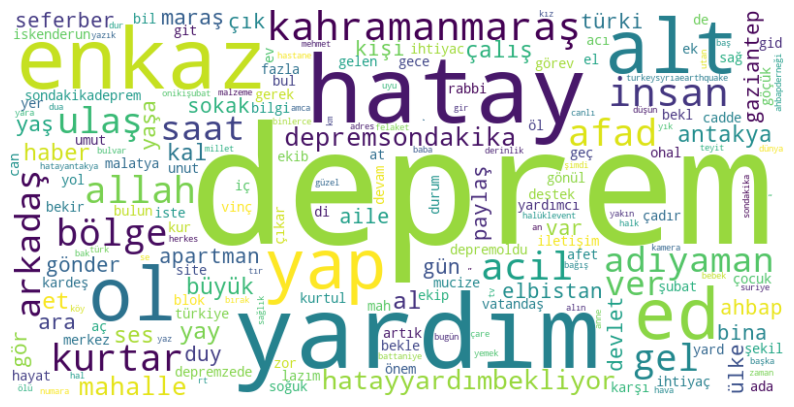

In [162]:
all_words = []
for text in df["content_no_rare_words"]:
    all_words.extend(text)  

word_counts = Counter(all_words)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [163]:
df.head()

,timestamp,username,handle,tweet_date,content,content_ment_link,content_wo_punct,content_wo_removed_english,content_wo_normalize,content_wo_tokenize,content_wo_stop,content_wo_lemmatized,content_no_rare_words
0,2024-11-03 19:38:25,Orhan Şevik,orhan_sevik,"Feb 8, 2023",@haluklevent\n @oguzhanugur\n hepinizden alla...,\n \n hepinizden allah razı olsun iyiki varsı...,hepinizden allah razı olsun iyiki varsını...,hepinizden allah razı olsun iyiki varsınız deprem,hepinizden allah razı olsun iyi ki varsınız de...,"[hepinizden, allah, razı, olsun, iyi, ki, vars...","[hepinizden, allah, razı, varsınız, deprem]","[hep, allah, razı, var, deprem]","[hep, allah, razı, var, deprem]"
1,2024-11-03 19:38:25,nursena,nurssxx_,"Feb 8, 2023",allahım nolur sen onlara dayanma gücü ver #deprem,allahım nolur sen onlara dayanma gücü ver #deprem,allahım nolur sen onlara dayanma gücü ver deprem,allahım nolur onlara dayanma gücü ver deprem,allahım ne olur onlara dayanma gücü ver deprem,"[allahım, ne, olur, onlara, dayanma, gücü, ver...","[allahım, onlara, dayanma, gücü, ver, deprem]","[allah, o, dayan, güc, ver, deprem]","[allah, o, dayan, güc, ver, deprem]"
2,2024-11-03 19:38:25,Elif ŞEKER,55ellllllif,"Feb 8, 2023",replying to \n@haluklevent\n @danlabilic\n and...,replying to \n\n \n and \n_harun\nadıyamanda a...,replying to and harun adıyamanda ali taş...,harun adıyamanda ali taşı mahallesi sokak hic...,harun adıyamanda ali taşı mahallesi sokak hicr...,"[harun, adıyamanda, ali, taşı, mahallesi, soka...","[harun, adıyamanda, ali, taşı, mahallesi, soka...","[haru, adıyaman, ali, taşı, mahalle, sokak, hi...","[adıyaman, ali, taşı, mahalle, sokak, apartman..."
3,2024-11-03 19:38:25,Yusuf,yusufaltuns,"Feb 8, 2023",tuğba södekoğlu kovulsun \n@showtv\n #deprem,tuğba södekoğlu kovulsun \n\n #deprem,tuğba södekoğlu kovulsun deprem,tuğba södekoğlu kovulsun deprem,tuğba sodekoğlu kovulsun deprem,"[tuğba, sodekoğlu, kovulsun, deprem]","[tuğba, sodekoğlu, kovulsun, deprem]","[tuğba, sodekoğlu, kov, deprem]",[deprem]
4,2024-11-03 19:38:25,𝐎̈𝐳𝐠𝐮̈𝐫 𝐑𝐚𝐧,dryghtn2,"Feb 8, 2023",arkadaşimiza ulaşamiyoruz\nkahramanmaraş elbis...,arkadaşimiza ulaşamiyoruz\nkahramanmaraş elbis...,arkadaşimiza ulaşamiyoruz kahramanmaraş elbist...,arkadaşimiza ulaşamiyoruz kahramanmaraş elbist...,arkadaşımıza ulaşamıyoruz kahramanmaraş elbist...,"[arkadaşımıza, ulaşamıyoruz, kahramanmaraş, el...","[arkadaşımıza, ulaşamıyoruz, kahramanmaraş, el...","[arkadaş, ulaş, kahramanmaraş, elbistan, pınar...","[arkadaş, ulaş, kahramanmaraş, elbistan, mahal..."


In [164]:
df.to_csv('tweets_cleaned.csv', index=False)